In [1]:
import os
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from dask_ml.wrappers import ParallelPostFit

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import model_prep_and_evals as mpe

from joblib import dump

In [2]:
# **************************************************************
# whole_set = True => merge train+test sets and train model with combined dataset
# whole_set = False => train model only with train set
whole_set = False

# **************************************************************

In [3]:
# open train data & select features and labels
# select features from r (Red band) to avg_lidar
# excludes x,y, pts_crs, aoi, naip_id, polygon_id, iceplant and lidar features
X_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'r':'day_in_year']

# select iceplant feature column
y_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'iceplant'] 

# --------------------------------------------------------------------
# open test data & select features and labels
X_test = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','test_set.csv')).loc[:,'r':'day_in_year']
y_test = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','test_set.csv')).loc[:,'iceplant'] 

if whole_set == True:
    X_train = pd.concat([X_train, X_test], axis=0)
    y_train = pd.concat([y_train, y_test], axis=0)

In [4]:
feature_names = X_train.columns.to_list()
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [5]:
rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)
dump(rfc, 'spectral_rfc.joblib')

['spectral_rfc.joblib']

In [6]:
# TO DO: make txt with model metadata. Include feature names in order
# TO DO: include model's cross validation?

In [7]:
if whole_set == False:
    preds = rfc.predict(X_test.to_numpy())
    mpe.print_accuracy_info(y_test.to_numpy(),preds)

true negatives: 148551     false positives: 5722
false negatives: 5983     true positives: 71112

sensitivity (TP/P): 92.24 %
specificity (TN/N): 96.29 %
G-mean:  0.94

precision (TP/(TP+FP)): 92.55 %

MCC:  0.8860575381299581

F1-measure:  0.92396
F0.5-measure (min false positives):  0.9249
F2-measure (min false negatives)  :  0.92302

accuracy: 94.94 %


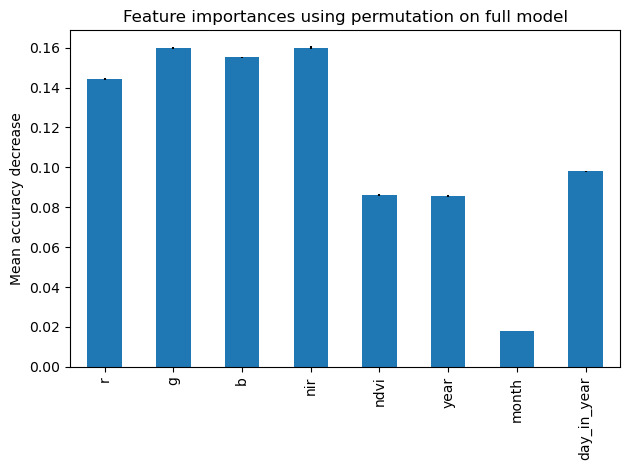

In [8]:
result = permutation_importance(
    rfc, 
#    X_test.drop('avg_lidar',  axis = 1,inplace=True),
    X_test.to_numpy(),
    y_test.to_numpy(),
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()